In [43]:
import pandas as pd
import geopandas as gpd

from fiona.drvsupport import supported_drivers


In [7]:
supported_drivers['KML'] = 'rw'



In [22]:
df = gpd.read_file('Community.kml', driver='KML')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [159]:
df

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.41999 25.20902 0.00000, 55.4210..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.39830 25.29000 0.00000, 55.3991..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.46027 25.27242 0.00000, 55.4598..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.37906 25.10325 0.00000, 55.3790..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.28809 25.24352 0.00000, 55.2882..."
...,...,...,...
221,kml_222,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.31673 25.23062 0.00000, 55.3165..."
222,kml_223,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.64166 25.15146 0.00000, 55.6416..."
223,kml_224,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.13270 25.06474 0.00000, 55.1334..."
224,kml_225,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.63303 25.19255 0.00000, 55.6113..."


<AxesSubplot: >

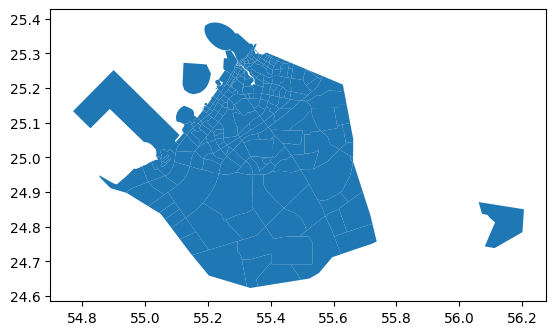

In [139]:
df.plot()

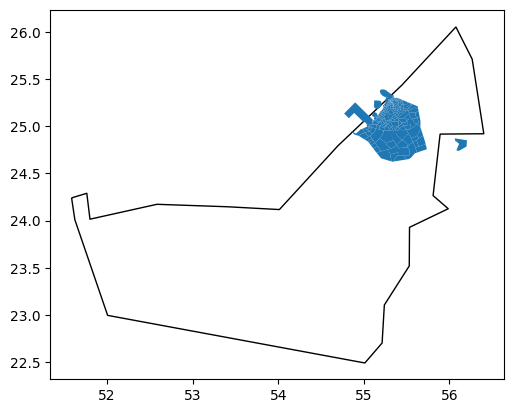

In [92]:
base = world[world.iso_a3 == 'ARE'].plot(color='white', edgecolor='black')

df.plot(ax=base);

In [206]:
gpd.tools.geocode("Dubai Silicon Oasis").explore()

In [112]:
data = pd.read_csv('transactions-2023-01-11.csv')

In [108]:
areas = data[['Area', 'Amount']].groupby('Area').Amount.agg(['median', 'size'])
areas

,median,size
Area,,
AKOYA OXYGEN,1.040000e+06,3710
AL BARARI,1.628361e+06,974
AL FURJAN,9.221600e+05,4616
AL HABTOOR POLO,6.000000e+08,1
AL KHAIL GATE,4.055100e+06,1
...,...,...
Wadi Alshabak,1.000000e+06,346
Warsan First,5.335000e+05,143
Warsan Fourth,3.656000e+06,1


In [149]:
gpd.tools.geocode(areas.index[:50]).explore()

In [152]:
gpd.tools.geocode(areas.index[:5])['address'].iloc[0]

'Akoya Oxygen Boundary, Damac Hills Junipter, Damac Hills Junipter, دبي, الإمارات العربية المتحدة'

In [193]:
not_exist = []
merged_list = []

def merge_data_to_df(df, data, point, data_area_name):
    point_locations = df[df['geometry'].contains(point)]
    if point_locations.shape[0] > 1:
        print('!!!')
        
    if point_locations.shape[0]:
        point_location = point_locations.iloc[0]
        return {
            'data_area_name': data_area_name,
            'point': point,
            'geometry': point_location['geometry'],
            'description': point_location['Description'],
            'median_amount': data.loc[i]['median'],
            'transaction_count': data.loc[i]['size'],
        }
        
    return None

for i in areas.index:
    point = gpd.tools.geocode(i).loc[0]['geometry']
    
    point_location_object = merge_data_to_df(df, areas, point, i)
    if point_location_object:
        merged_list = merged_list + [point_location_object]
    else:
        point = gpd.tools.geocode('Dubai ' + i).loc[0]['geometry']
        point_location_object = merge_data_to_df(df, areas, point, i)
        if point_location_object:
            merged_list = merged_list + [point_location_object]
        else:
            not_exist = not_exist + [i]

In [210]:
merged_list

[{'data_area_name': 'AKOYA OXYGEN',
  'point': <POINT (55.403 24.984)>,
  'geometry': <POLYGON Z ((55.365 24.964 0, 55.369 24.966 0, 55.373 24.967 0, 55.376 24.96...>,
  'description': '<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>CNAME_E</th> <td>AL YUFRAH 4</td> </tr><tr bgcolor=""> <th>CNAME_A</th> <td>اليفره 4</td> </tr><tr bgcolor="#E3E3F3"> <th>OBJECTID</th> <td>222</td> </tr><tr bgcolor=""> <th>LABEL_E</th> <td>AL YUFRAH 4</td> </tr><tr bgcolor="#E3E3F3"> <th>LABEL_A</th> <td>اليفره 4</td> </tr><tr bgcolor=""> <th>C_PREFIX_E</th> <td>Community:</td> </tr><tr bgcolor="#E3E3F3"> <th>C_PREFIX_A</th> <td></td> </tr><tr bgcolor=""> <th>COMMUNITY_</th> <td>AL YUFRAH 4 - 919</td> </tr><tr bgcolor="#E3E3F3"> <th>COMMUNITY1</th> <td>اليفره 4 - 919</td> </tr><tr bgcolor=""> <th>DGIS_ID</th> <td>0000252</td> </tr><tr bgcolor="#E3E3F3"> <th>COMM_NUM</th> <td>919</td> </tr><tr bgcolor=""> <th>NDGIS_ID</th> <td>252</td> </tr><tr

In [200]:
areas.loc[not_exist]

,median,size
Area,,
Al Eyas,1.300000e+08,1
Al Goze First,1.650000e+06,97
Al Goze Fourth,2.450000e+06,18
Al Goze Second,1.000000e+06,92
Al Goze Third,1.000000e+08,7
Al Hebiah Fourth,3.333000e+06,1885
Al Hebiah Sixth,2.286500e+06,630
Al Khabeesi,1.187502e+07,38
Al Kheeran,2.400000e+06,122


In [245]:
areas_with_geometry = pd.DataFrame(merged_list)

In [246]:
areas_with_geometry

,data_area_name,point,geometry,description,median_amount,transaction_count
0,AKOYA OXYGEN,POINT (55.4034216 24.9835424),POLYGON Z ((55.3648398724616 24.9642909499132 ...,<center><table><tr><th colspan='2' align='cent...,1.040000e+06,3710.0
1,AL BARARI,POINT (55.30411491216756 25.096941649999998),POLYGON Z ((55.3649438016522 25.1199009692512 ...,<center><table><tr><th colspan='2' align='cent...,1.628361e+06,974.0
2,AL FURJAN,POINT (55.14382772063573 25.02836395),POLYGON Z ((55.1327018281843 25.0647370031179 ...,<center><table><tr><th colspan='2' align='cent...,9.221600e+05,4616.0
3,AL HABTOOR POLO,POINT (55.3680618 25.0805325),POLYGON Z ((55.3790560984075 25.1032459761778 ...,<center><table><tr><th colspan='2' align='cent...,6.000000e+08,1.0
4,AL KHAIL GATE,POINT (55.25236630469304 25.13992785),POLYGON Z ((55.253991736505 25.1441927067565 0...,<center><table><tr><th colspan='2' align='cent...,4.055100e+06,1.0
...,...,...,...,...,...,...
242,Wadi Al Safa 5,POINT (55.3664589 25.0795209),POLYGON Z ((55.3790560984075 25.1032459761778 ...,<center><table><tr><th colspan='2' align='cent...,3.180888e+06,1439.0
243,Wadi Al Safa 7,POINT (55.2678012297605 25.05011125),POLYGON Z ((55.3011654351545 25.0582734720443 ...,<center><table><tr><th colspan='2' align='cent...,5.385600e+05,823.0
244,Warsan First,POINT (55.422077 25.1631537),POLYGON Z ((55.4011864628332 25.1788812213664 ...,<center><table><tr><th colspan='2' align='cent...,5.335000e+05,143.0
245,Warsan Fourth,POINT (55.422077 25.1631537),POLYGON Z ((55.4011864628332 25.1788812213664 ...,<center><table><tr><th colspan='2' align='cent...,3.656000e+06,1.0


In [247]:
areas_with_geometry = gpd.GeoDataFrame(areas_with_geometry.groupby('description', as_index=False).agg({
    'data_area_name': 'first', 
    'geometry': 'first', 
    'point': 'first', 
    'median_amount': 'median', 
    'transaction_count': 'sum'
}))

<AxesSubplot: >

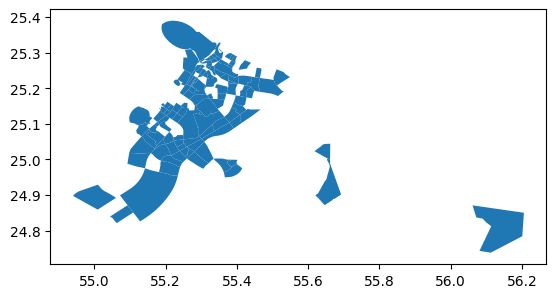

In [248]:
areas_with_geometry['geometry'].plot()

<AxesSubplot: >

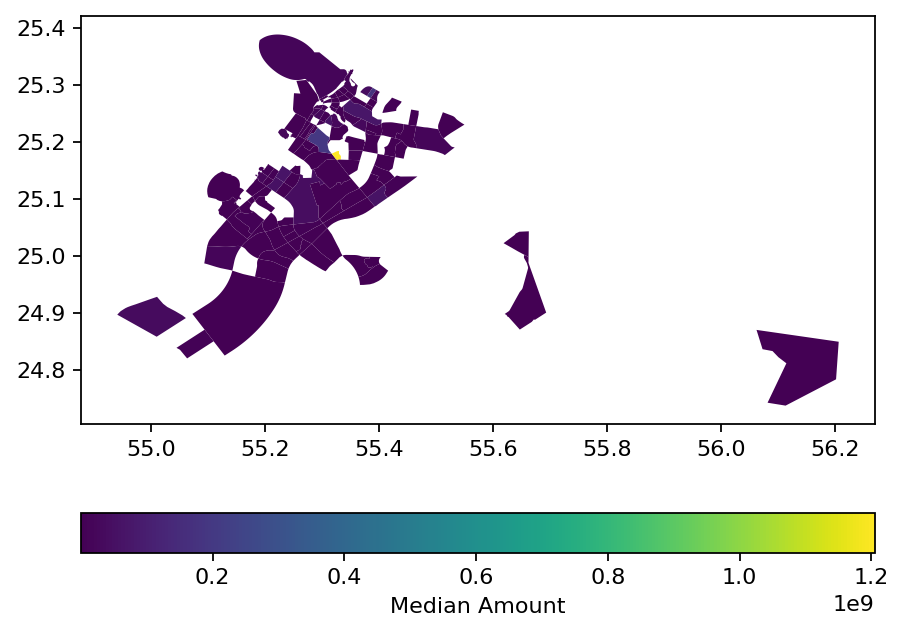

In [263]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

fig.dpi = 160

areas_with_geometry.plot(column='median_amount',
           ax=ax,
           legend=True,
           figsize=(30, 25),
           legend_kwds={'label': "Median Amount",
                        'orientation': "horizontal"})

<AxesSubplot: >

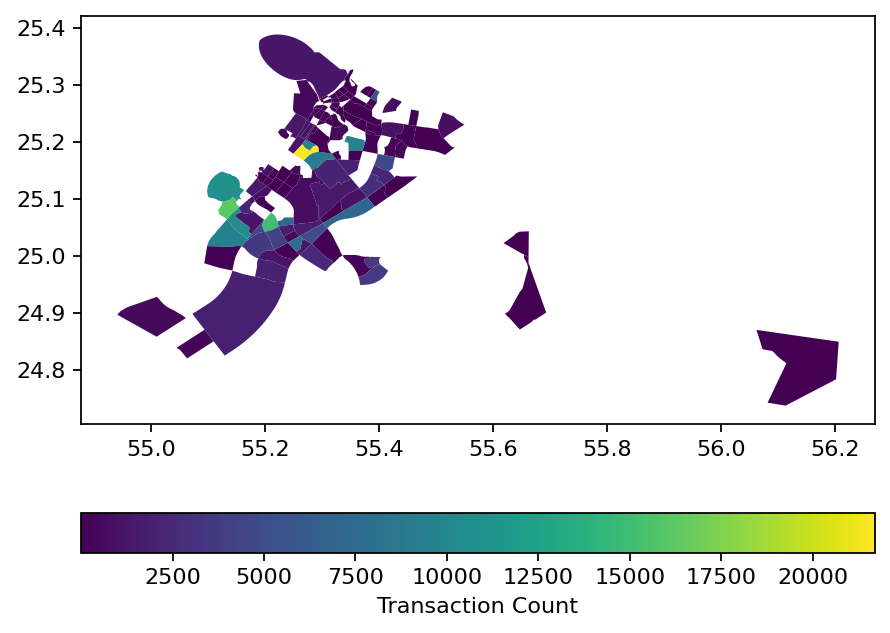

In [264]:
fig, ax = plt.subplots(1, 1)

fig.dpi = 160

areas_with_geometry.plot(column='transaction_count',
           ax=ax,
           legend=True,
           figsize=(30, 25),
           legend_kwds={'label': "Transaction Count",
                        'orientation': "horizontal"})